# Neural Network Basic Working 

In [2]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

#### Understanding Derivatives - Gradient Calculation

In [3]:
# Consider a function as shown below.
def f(x):
    return 6*x**2 + 4*x + 2

In [4]:
f(4)

114

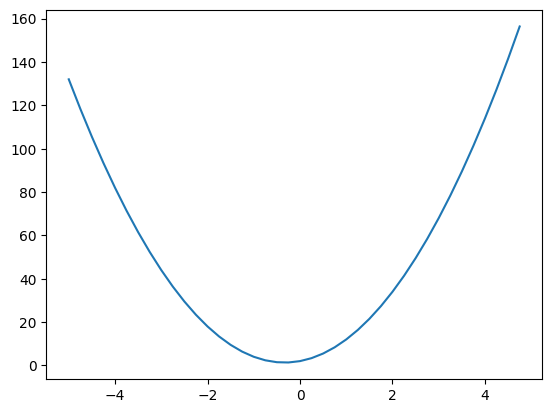

In [7]:
x_values = np.arange(-5, 5, 0.25)
y_values =  f(x_values)
plt.plot(x_values, y_values)
plt.show()

In [10]:
# To calculate the derivate the formula f(x+h)-f(x)/h can be used.
# Manually doing the derivate of the above fucntion gives us d/dx(6*x**2 + 4*x + 2) = 12x + 4
def f_derivative(x):
    return 12*x + 4

print(f'Derivative from manual calculation = {f_derivative(4)}')

h = 0.0000001 # as h tends to 0
derivative_formula = (f(4+h) - f(4))/h
print(f'Derivative from formula calculation = {derivative_formula}')

# In Neural Networks the second way is used to calculate the derivatives or gradients. 

Derivative from manual calculation = 52
Derivative from formula calculation = 52.00000089189416


#### Code for visualization of Neural Network

In [30]:
# Reference: https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n.op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n.op, label = n.op)
      # and connect this node to it
      dot.edge(uid + n.op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.op)

  return dot


# Value Class Definition

In [147]:
class Value:
    def __init__(self, data, child=(), op='', label = ''):
        self.data = data
        self.prev = set(child)
        self._backward = lambda: None
        self.op = op
        self.label = label
        self.grad = 0

    def __repr__(self) -> str:
        return f'Value(data = {self.data})'
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other): # other + self
        return self + other 
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - (out.data**2)*out.grad)
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    build_topo(child)
                    topo.append(v)
        build_topo(self)
        #print(topo)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [33]:
x = Value(2)
y = Value(3)

# Addition and multiplication operations can be performed on Value
# Similarly other operations can be added. 
z = x + y
r = x * y
print(z,',', r)

Value(data = 5) , Value(data = 6)


In [36]:
# keeping track of previous nodes and operations performed by adding prev and op in class Value
print(f'Previous Nodes are = {z.prev}')
print(f'Operation Performed is = {z.op}')

Previous Nodes are = {Value(data = 2), Value(data = 3)}
Operation Performed is = +


In [86]:
# using basic operations of value to build a neural net
a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = Value(4.0, label='c')
g = Value(2.0, label='g')
d = a*b; d.label =  'd'
e = d + c; e.label = 'e'
f = e * g; f.label = 'f'
f

Value(data = 20.0)

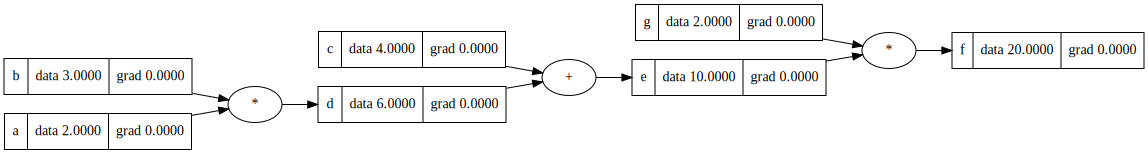

In [87]:
draw_dot(f)

In [88]:
def grad():
    a = Value(2.0, label='a')
    b = Value(3.0, label='b')
    c = Value(4.0, label='c')
    g = Value(2.0, label='g')
    d = a*b; d.label =  'd'
    e = d + c; e.label = 'e'
    f = e * g; f.label = 'f'
    
    h = 0.0001 
    a = Value(2.0+h, label='a')
    b = Value(3.0, label='b')
    c = Value(4.0, label='c')
    g = Value(2.0, label='g')
    d = a*b; d.label =  'd'
    e = d + c; e.label = 'e'
    f1 = e * g; f.label = 'f'
    return (f1.data - f.data)/h # derivative formula
grad()

6.000000000021544

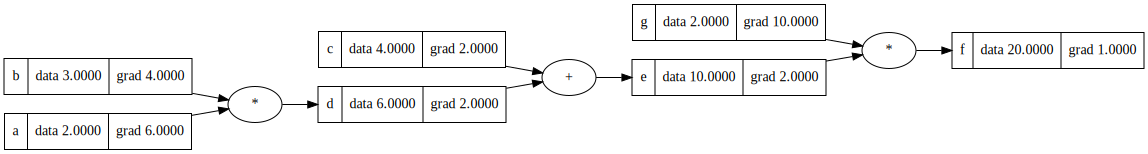

In [89]:
# gradient of f = increase f by h in above code
f.grad = 1
# gradient of g and e - increase g and e by h in above code
g.grad = 10
e.grad = 2
# gradient of d and c 
d.grad = 2
c.grad = 2
# gradient of a and b 
b.grad = 4
a.grad = 6
# Visualize
draw_dot(f)

# from above it can be observed that when there is + operation it just passes the gradients and when there is * it uses chain rule - multiplies the gradient with other term value

In [90]:
# when nudged in the direction of gradient then the output should move towards the +ve direction
# moving in the direction of gradient
a.data += 0.01*a.grad
b.data += 0.01*b.grad
c.data += 0.01*c.grad
g.data += 0.01*g.grad

d = a*b
e = d + c
f = e * g
f
# it can be observed that moving in direction of gradient value of e moves towards the positive direction.
# i.e we get 21.59304 as e to the previous one which was 20

Value(data = 21.59304)

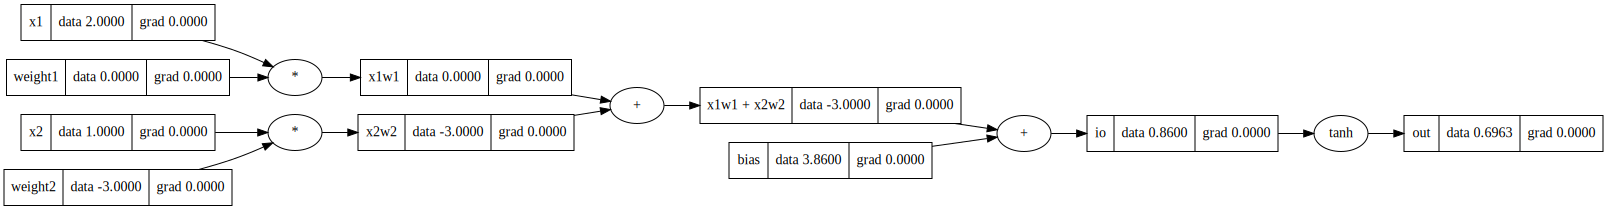

In [138]:
# Building Perceptron
#----------------------------------------------------
# inputs
x1 = Value(2.0); x1.label = 'x1'
x2 = Value(1.0); x2.label = 'x2'
# weights
w1 = Value(0.0); w1.label = 'weight1'
w2 = Value(-3.0); w2.label = 'weight2'
# bias
b = Value(3.860); b.label = 'bias'

# calculations - x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

io = x1w1x2w2 + b; io.label ='io'
out = io.tanh(); out.label= 'out'

#Visualize
draw_dot(out)

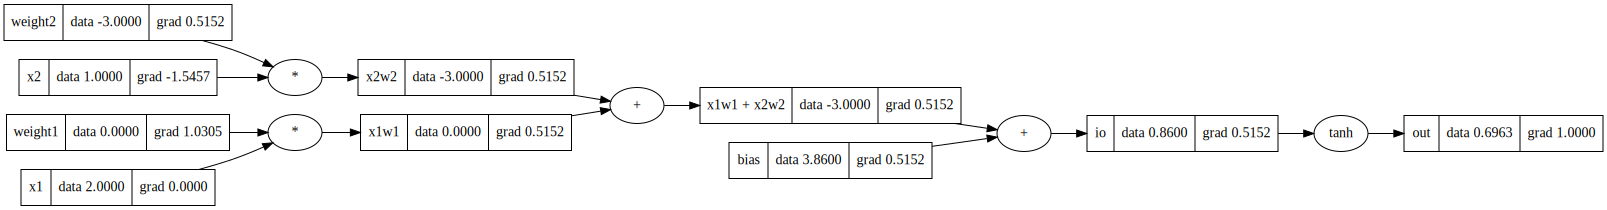

In [115]:
# manual backpropagation
#-------------------------------
out.grad = 1
# derivative of tanh
ix = 1-(out.data)**2
io.grad = ix
# as operation is +
b.grad = ix
x1w1x2w2.grad = ix
# as the operation is +
x1w1.grad = ix
x2w2.grad = ix
# x1, w1, x2, w2
x1.grad = w1.data * x1w1.grad # chain rule
w1.grad = x1.data * x1w1.grad # chain rule

x2.grad = w2.data * x2w2.grad # chain rule
w2.grad = x2.data * x2w2.grad # chain rule



# visualization
draw_dot(out)

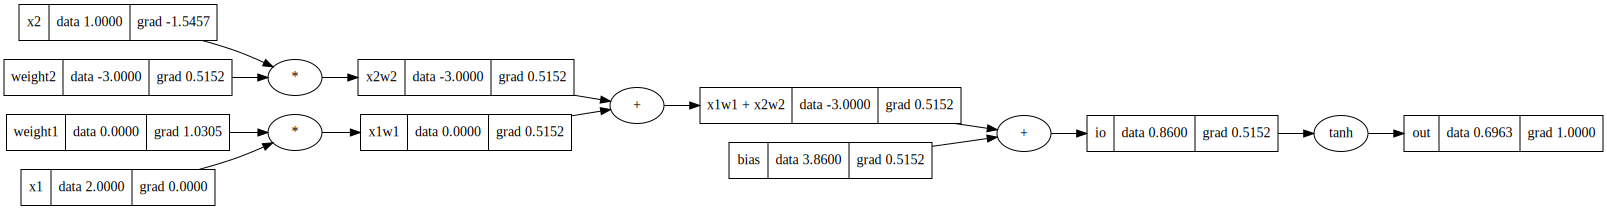

In [121]:
# Backpropagation with calling backward function.
# -----------------------------------------------

# setting out grad to 1.0
out.grad = 1.0
# calling backward on each node
out.backward()
io.backward()
x1w1x2w2.backward()
x1w1.backward()
x2w2.backward()

# visalizing the NN
draw_dot(out)

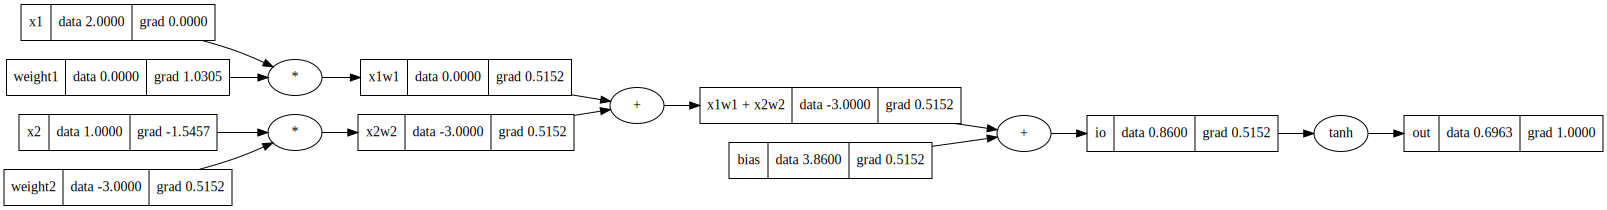

In [140]:
# After having backward in the class of Value. 
out.backward()
draw_dot(out)